In [303]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import*

In [304]:
mpl.rcParams['font.size'] = 16

In [305]:
# System matrix:
A = np.array([[1.1, 1],
               [0,  1]])
nx = A.shape[1]
print(A)
print('A.shape = {}'.format(A.shape))

[[1.1 1. ]
 [0.  1. ]]
A.shape = (2, 2)


In [306]:
B = np.array([[0.5],
            [1]])

nu = B.shape[1]
print(B)
print('B.shape = {}'.format(B.shape))

[[0.5]
 [1. ]]
B.shape = (2, 1)


[1.1 1. ]


(-1.25, 1.25)

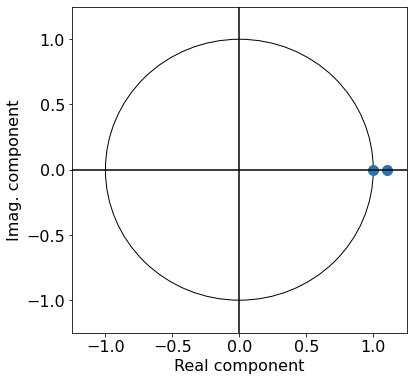

In [307]:
lam, v = np.linalg.eig(A)
print(lam)
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlabel('Real component')
ax.set_ylabel('Imag. component')
ax.add_artist(plt.Circle((0, 0), 1,edgecolor='k', fill=False))
ax.plot(np.real(lam),np.imag(lam),'o', markersize=10)
ax.axhline(0,color='k')
ax.axvline(0,color='k')
ax.set_ylim(-1.25,1.25)
ax.set_xlim(-1.25,1.25)

In [308]:
x = SX.sym("x",nx,1)
u = SX.sym("u",nu,1)

In [309]:
x_next = A@x + B@u 

# Create the CasADi function
system = Function("sys",[x,u],[x_next])

print(x_next)

[(((1.1*x_0)+x_1)+(0.5*u)), (x_1+u)]


In [310]:
x0 = np.ones((2,1))
u0 = np.ones((1,1))
system(x0,u0)

DM([2.6, 2])

In [311]:
# Define the total steps to simulate
N_sim = 10
# Define the initial condition
x_0 = np.array([2,1]).reshape(2,1)
# Define the input (for the moment consider u = 0)
u_k = 0

res_x = [x_0]

In [312]:
for i in range(N_sim):
    x_next = system(x_0,u_k)
    res_x.append(x_next)
    x_0 = x_next
    

# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)
print(res_x)

[[ 2.          3.2         4.52        5.972       7.5692      9.32612
  11.258732   13.3846052  15.72306572 18.29537229 21.12490952]
 [ 1.          1.          1.          1.          1.          1.
   1.          1.          1.          1.          1.        ]]


In [313]:
res_x.shape

(2, 11)

Text(0.5, 0, 'time')

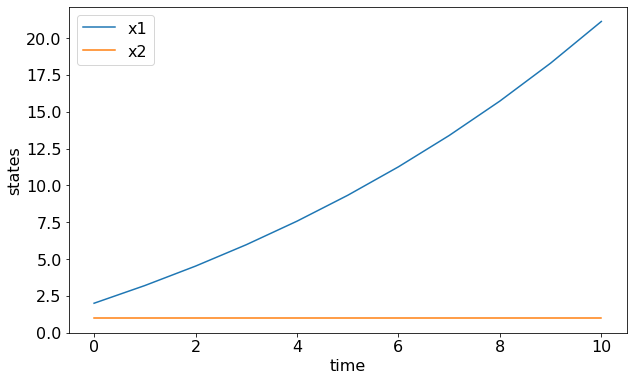

In [314]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
lines = ax.plot(res_x.T)
ax.legend(lines, ['x1', 'x2'])

# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

In [315]:
Q = 1
Q = Q*np.diag(np.ones(nx))
print(Q)

[[1. 0.]
 [0. 1.]]


In [316]:
R = 0.1
R = np.diag(R*np.ones(nu))
print(R)
N= 10

[[0.1]]


In [317]:
# stage cost
stage_cost = x.T@Q@x+ u.T@R@u
stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

# terminal cost
terminal_cost = x.T@Q@x
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

In [318]:
# state constraints
lb_x = -2*np.ones((nx,1))
ub_x = 2*np.ones((nx,1))
# input constraints
lb_u = -1*np.ones((nu,1))
ub_u = 1*np.ones((nu,1))

In [319]:
X = SX.sym("X",(N+1)*nx,1)
U = SX.sym("U",N*nu,1)

In [320]:
J = 0
lb_X = [] # lower bound for X.
ub_X = [] # upper bound for X
lb_U = [] # lower bound for U
ub_U = [] # upper bound for U
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

In [321]:
k=1
x_k = X[k*nx:(k+1)*nx,:]
print(x_k)

[X_2, X_3]


In [322]:
for k in range(10):
    # 01 - Your code here!
    x_k = X[k*nx:(k+1)*nx,:]
    x_k_next = X[(k+1)*nx:(k+2)*nx,:]
    u_k = U[k*nu:(k+1)*nu,:]
    # 01
    # 02 - Your code here!
    # objective
    J += stage_cost_fcn(x_k,u_k)
    # 02
    #print("J=")
    #print(J)
    # 03 - Your code here!
    # equality constraints (system equation)
    x_k_next_calc = system(x_k,u_k)
    # 03
    #print(x_k_next_calc)
    # 04 - Your code here!
    g.append(x_k_next - x_k_next_calc)
    lb_g.append(np.zeros((nx,1)))
    ub_g.append(np.zeros((nx,1)))
    # 04

    # 05 - Your code here!
    lb_X.append(lb_x)
    #print(lb_x)
    ub_X.append(ub_x)
    #print(ub_x)
    lb_U.append(lb_u)
    #print(lb_u)
    ub_U.append(ub_u)
    #print(ub_u)
    # 05

In [323]:
X.shape

(22, 1)

In [324]:
x_terminal = X[N*nx:(N+1)*nx,:]
print(x_terminal)
J += terminal_cost_fcn(x_terminal)
lb_X.append(lb_x)
ub_X.append(ub_x)

[X_20, X_21]


In [325]:
X.shape
print(ub_X)

[array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]]), array([[2.],
       [2.]])]


In [326]:
lbx = vertcat(*lb_X, *lb_U)
print(lbx.shape)
ubx = vertcat(*ub_X, *ub_U)
x = vertcat(X,U)
g = vertcat(*g)
lbg = vertcat(*lb_g)
ubg = vertcat(*ub_g)
print(J.shape)
print(x.shape)
print(g.shape)
prob = {'f':J,'x':x,'g':g}
solver = nlpsol('solver','ipopt',prob)

(32, 1)
(1, 1)
(32, 1)
(20, 1)


In [327]:
x.shape
print(ubx)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [328]:
print(solver)

solver:(x0[32],p[],lbx[32],ubx[32],lbg[20],ubg[20],lam_x0[32],lam_g0[20])->(x[32],f,g[20],lam_x[32],lam_g[20],lam_p[]) IpoptInterface


In [329]:
x_0 = np.array([-2,2]).reshape(2,1)

In [330]:
print(x_0)

[[-2]
 [ 2]]


In [331]:
print(nx)

2


In [332]:
print(lbx.shape)
print(ubx.shape)

(32, 1)
(32, 1)


In [333]:
lbx[:nx]=x_0
ubx[:nx]=x_0
print(lbx.shape)
print(ubx.shape)
print(lbx[:nx])

(32, 1)
(32, 1)
[-2, 2]


In [334]:


res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)

X = res['x'][:(N+1)*nx].full().reshape(N+1, nx)
U = res['x'][(N+1)*nx:].full().reshape(N, nu)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       67
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       30

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 8

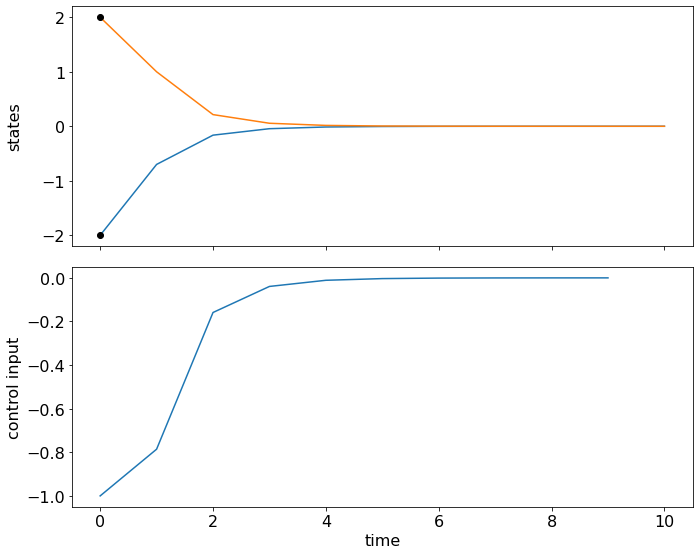

In [335]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(X)
ax[1].plot(U)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

# Highlight the selected initial state (the lines should start here!)
ax[0].plot(0,x_0.T, 'o', color='black')

fig.align_ylabels()
fig.tight_layout()

In [336]:
x_0 = np.array([2,-2]).reshape(2,1)
res_x = [x_0]
res_u = []
print(x_0)
N_sim = 20

[[ 2]
 [-2]]


In [337]:
for i in range(N_sim):
    # fix initial condition of the state:
    lbx[:nx]=x_0
    ubx[:nx]=x_0
    print(lbx)
    print(ubx)
    # solve optimization problem
    res = solver(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg)
    u_k = res['x'][(N+1)*nx:(N+1)*nx+nu,:]
    
    res_u.append(u_k)
    print(res_u)
    
    # simulate the system
    x_next = system(x_0,u_k)
    res_x.append(x_next)
    x_0 = x_next
    print(res_x)
# Make an array from the list of arrays:
res_x = np.concatenate(res_x,axis=1)
res_u = np.concatenate(res_u, axis=1)

[2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[2, -2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       67
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       30

Total number of variables............................:       30
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       30
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:

   1 4.7327615e-010 8.47e-022 9.71e-017  -1.0 9.83e-006    -  1.00e+000 1.00e+000h  1
   2 4.7096713e-010 2.12e-022 1.08e-017  -2.5 7.12e-007    -  1.00e+000 1.00e+000h  1
   3 4.7094874e-010 1.06e-021 2.98e-019  -3.8 1.24e-007    -  1.00e+000 1.00e+000h  1
   4 4.7094874e-010 8.47e-022 2.27e-020  -5.7 1.03e-009    -  1.00e+000 1.00e+000h  1
   5 4.7094874e-010 1.06e-022 2.33e-021  -8.6 4.96e-012    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 5

                                   (scaled)                 (unscaled)
Objective...............:  4.7094874298969521e-010   4.7094874298969521e-010
Dual infeasibility......:  2.3293406049493259e-021   2.3293406049493259e-021
Constraint violation....:  1.0587911840678754e-022   1.0587911840678754e-022
Complementarity.........:  2.5059035688260162e-009   2.5059035688260162e-009
Overall NLP error.......:  2.5059035688260162e-009   2.5059035688260162e-009


Number of objective function evaluations             = 6
Number of objective gradi

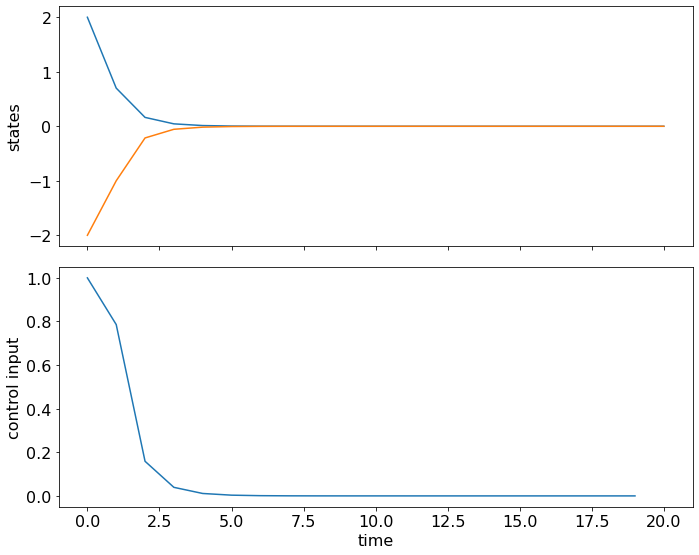

In [338]:
fig, ax = plt.subplots(2,1, figsize=(10,8), sharex=True)
ax[0].plot(res_x.T)
ax[1].plot(res_u.T)
ax[0].set_ylabel('states')
ax[1].set_ylabel('control input')
ax[1].set_xlabel('time')

fig.align_ylabels()
fig.tight_layout()